In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import time
import scienceplots
import torchsummary

import dataset
import data_Preprocess 
import models
import uLoss
import Metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('device = ',device)
seed = 123 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
plt.style.use('science')
plt.rcParams['text.usetex'] = False

c:\Users\asus\.conda\envs\myTorch_gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device =  cuda:0


In [2]:
param = {
    'mesh_size':[0.1,0.1],
    'structure_size':[10,10],
    'measurements_num':9,
    'device':device,
    'is_plotInputMap':False,
    'Lambda':0.0,
    'HS_region':torch.tensor(([[[1.5,2.5],[6.9,8.4]],# region_1
                               [[4.4,8.4],[7.2,8.0]],# region_2
                               [[0.6,1.6],[5.0,6.0]],# region_3(1)
                               [[0.6,3.1],[4.0,5.0]],# region_3(2)
                               [[1.0,4.0],[0.8,2.8]],# region_4
                               [[5.6,8.6],[1.3,4.9]]])),# region_5
    'BCs':['Neumann','Convection','Radiation','Radiation'],# top,bottom,left,right
    'Heat Transfer Rate':52,
    'Convective coe':10,
    'Emissivity':0.05,
    'q':15,
    'T_a':20,
    'BC_regular':True,
    'HS_regular':False,
    'Direchlet BC':20,
    'learning_rate': 0.02,
    'epochs': 20000,
    'dis_interval': 1000,
    'is_plotLoss':True,
    'is_plotResult':False,
    'layout': '_random'    
    
}

In [3]:
train_set = dataset.MyDataset('Train','Co-driven',param)
test_set = dataset.MyDataset('Test','Co-driven',param)
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                          batch_size = 32,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 100,
                                          shuffle = False)
trues = data_Preprocess.get_Tfields('Test').unsqueeze(1)

In [4]:
Unet = models.UNet(in_channels=1, out_channels=1, factors=2,param=param).to(device)
loss_fn = uLoss.UncertaintyLoss(param)
train_losses_epoch,loss_inner_epoch,loss_neumann_epoch,loss_radiation_epoch,loss_convection_epoch,loss_hsd_epoch = models._Train(Unet,train_loader,loss_fn,param)

Traing Epoch: 0, learning_rate = 0.02
loss = 37.766685, loss_hs = 37.766685, loss_inner = 0.003529
loss component -> loss_neumann = 0.068357, loss_radiation = 0.034728, loss_convection = 0.055693


KeyboardInterrupt: 

In [6]:
#torch.save(Unet,'Layout_9_empirical_2.pt')

tensor(0.1646, grad_fn=<MeanBackward0>)
tensor(18.6437, grad_fn=<SqrtBackward0>)


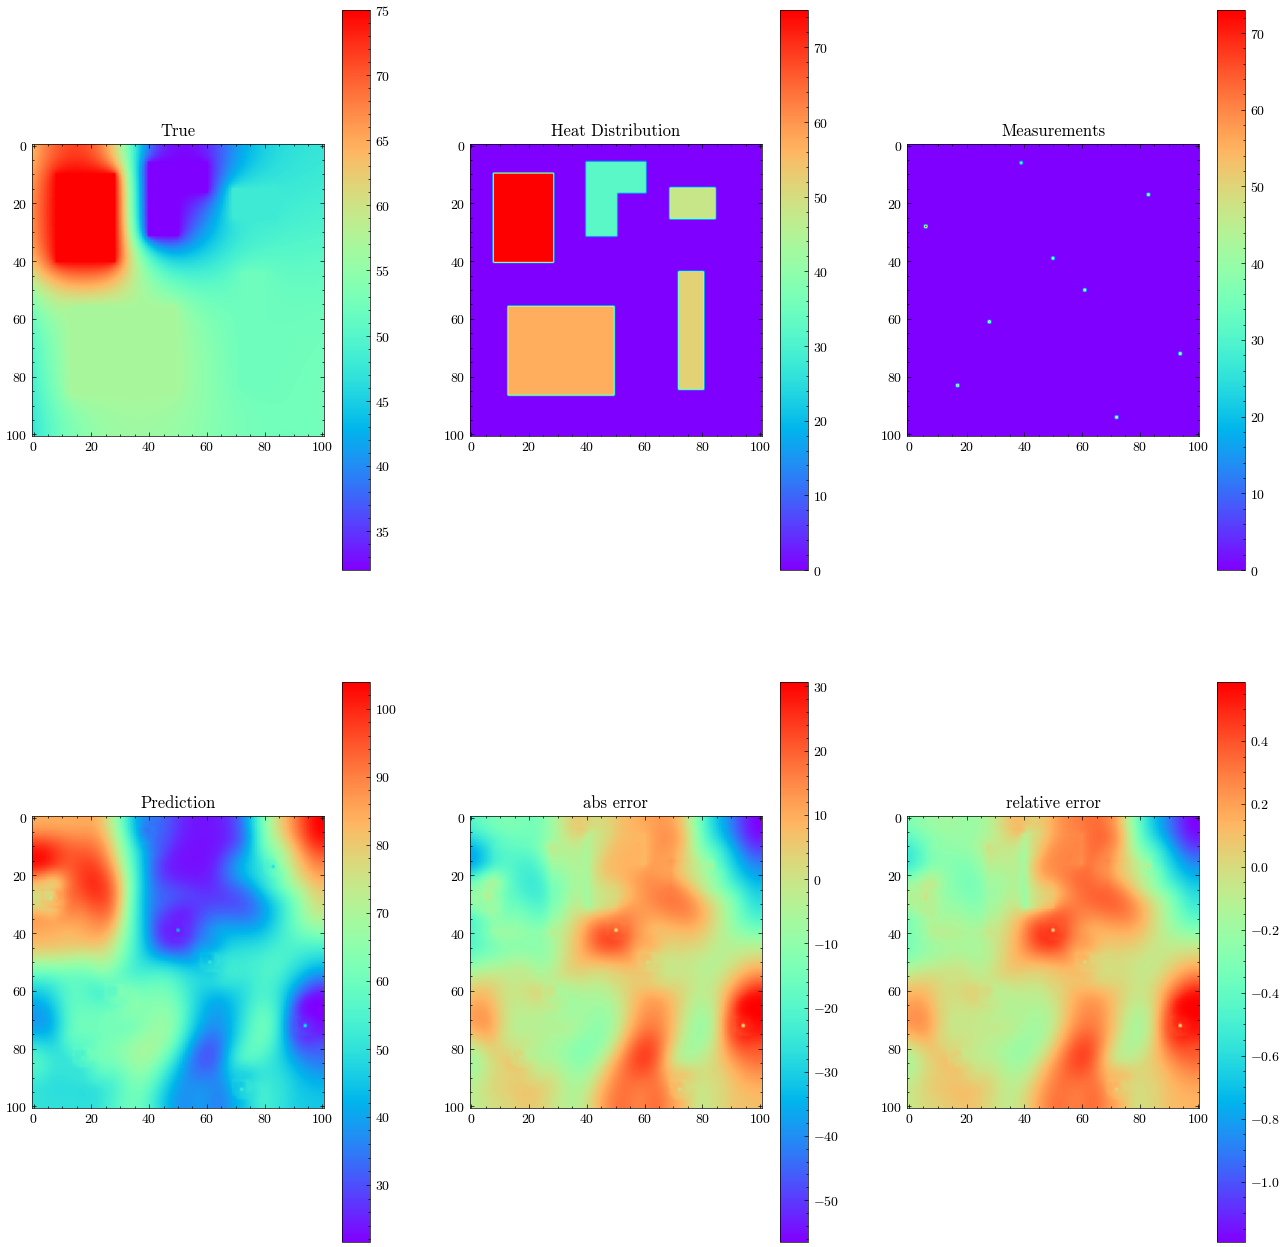

In [6]:
#Unet = torch.load('Layout-9.pt')
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
out = Unet(MP.unsqueeze(1))
out = uLoss.Fill_withMeasurements(out,MP,param)
#out = uLoss.HC_Convection(out,param)
#out = uLoss.Fill_withDirechletBC(out,param)
label = 0
print (Metrics.NMAE(out,trues))
print (Metrics.RMSE(out.cpu(),trues.cpu()))
plt.figure(figsize=(16,16))
plt.subplot(2,3,1)
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(HSD[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Heat Distribution')

plt.subplot(2,3,3)
plt.imshow(MP[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Measurements')

plt.subplot(2,3,4)
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction')

plt.subplot(2,3,5)
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('abs error')

plt.subplot(2,3,6)
plt.imshow(((trues[label][0]-out[label][0].cpu())/trues[label][0]).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('relative error')
plt.show()

In [7]:
fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_hsd_epoch,'-o',color='blue',label='loss_hs',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_inner_epoch,'-o',color='black',label='loss_inner',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_neumann_epoch,'-o',color='blue',label='loss_neumann',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_radiation_epoch,'-.',color='red',label='loss_radiation',linewidth=0.5,markersize=2)
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,3))
plt.plot(range(param['epochs']),loss_convection_epoch,'-*',color='black',label='loss_convection',linewidth=0.5,markersize=2)
plt.legend()
plt.show()


NameError: name 'loss_hsd_epoch' is not defined

<Figure size 1000x300 with 0 Axes>

In [12]:
print ('loss_hs = {}'.format(uLoss.loss_HSD(out,HSD,param)))
print ('loss_inner = {}'.format(uLoss.loss_T_inner(out,param)))
print ('loss_neumann = {}'.format(uLoss.loss_neumann(out,param)))
print ('loss_radiation = {}'.format(uLoss.loss_radiation(out,param)))
print ('loss_convection = {}'.format(uLoss.loss_convection(out,param)))

loss_hs = 0.15309295058250427
loss_inner = 0.0007880032062530518
loss_neumann = 0.0005219927988946438
loss_radiation = 0.0008571022772230208
loss_convection = 0.005576829891651869


In [13]:
print ('loss_hs = {}'.format(uLoss.loss_HSD(trues,HSD,param)))
print ('loss_inner = {}'.format(uLoss.loss_T_inner(trues,param)))
print ('loss_neumann = {}'.format(uLoss.loss_neumann(trues,param)))
print ('loss_radiation = {}'.format(uLoss.loss_radiation(trues,param)))
print ('loss_convection = {}'.format(uLoss.loss_convection(trues,param)))

loss_hs = 0.0
loss_inner = 0.0007096591871231794
loss_neumann = 4.6441702579613775e-05
loss_radiation = 0.0003792509960476309
loss_convection = 0.0004917915211990476


In [ ]:
label = 0
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(HSD[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Heat Distribution')

plt.subplot(2,2,3)
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction')

plt.subplot(2,2,4)
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('abs error')
plt.show()

In [13]:
torchsummary.summary(Unet.cuda(), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
         GroupNorm-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
         GroupNorm-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
     _EncoderBlock-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           4,640
        GroupNorm-10         [-1, 32, 112, 112]              64
             ReLU-11         [-1, 32, 112, 112]               0
           Conv2d-12         [-1, 32, 112, 112]           9,248
        GroupNorm-13         [-1, 32, 112, 112]              64
             ReLU-14         [-1, 32, 1